In [ ]:
!pip install agro-met-equations-dynalogic
!pip install arff
!pip install tensorflow

  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4970 sha256=12c827da06358045365edb6cac4ebdbb2279d290e37cb5155b26e5ffb62f7680
  Stored in directory: /root/.cache/pip/wheels/fe/81/bd/4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
from os import listdir
from os.path import isfile, join
import AgroMetEquations as AM
from datetime import datetime,date
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Opening the google drive data and gathering it into dataframes.**

In [ ]:
mypath='drive/MyDrive/dataNew'

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)
dataFrame=[]

latitude=[-3.81583,-3.74805555,-4.26138,-7.30083,-6.3963,-6.01749999,-5.1744,-5.1366,-4.78694,-5.186,-7.07777,-5.90555,-3.48416,-3.1211,-3.7322,-4.9788]
longitude=[-38.5377,-40.34583333,-38.9311,-39.271,-39.2688,-40.28138888,-39.28944,-38.3566,-37.7666,-40.6722,-40.36277,-38.62777,-39.5886,-40.0872,-41.01194,-39.0572]
height=[29.55,92.07,865.53,409.41,221.56,410.87,221.04,45.03,49,298.19,577.95,149.31,104.49,67.15,756,193]

for nameFile in onlyfiles:
  dataFrame.append(pd.DataFrame(pd.read_csv(str(mypath)+'/'+str(nameFile),sep=';')))


['dados_A305_H_2003-02-17_2021-11-25.csv', 'dados_A306_H_2003-02-11_2021-11-25.csv', 'dados_A314_H_2007-05-25_2021-11-25.csv', 'dados_A315_H_2007-05-30_2021-11-25.csv', 'dados_A319_H_2007-05-29_2021-11-25.csv', 'dados_A324_H_2007-07-11_2021-11-25.csv', 'dados_A325_H_2007-07-08_2021-11-25.csv', 'dados_A332_H_2007-08-23_2021-11-25.csv', 'dados_A339_H_2007-11-09_2021-11-25.csv', 'dados_A342_H_2008-12-10_2021-11-25.csv', 'dados_A347_H_2008-03-06_2021-11-25.csv', 'dados_A358_H_2008-09-09_2021-11-25.csv', 'dados_A359_H_2008-09-04_2021-11-25.csv', 'dados_A360_H_2009-04-21_2021-11-25.csv', 'dados_A368_H_2018-03-14_2021-11-25.csv', 'dados_A369_H_2018-03-19_2021-11-25.csv']


# **Creating latitude, longitude and height columns in dataframes.**

These data are related to the geographical position of the meteorological station. Each row in dataframe need to have latitude, longitude and height. When you go to make the prediction you will place these data from the exact point where you want to predict the E0 or nearest.

In [ ]:
size=len(latitude)
longitude_rad=[math.radians(longitude[i]) for i in range(size)]
latitude_rad=[math.radians(latitude[i]) for i in range(size)]

for i in range(len(onlyfiles)):
  dados_LA=[]
  dados_LO=[]
  dados_AL=[]
  size=len(dataFrame[i])
  
  dados_LA=[latitude_rad[i] for z in range(size)]
  dados_LO=[longitude_rad[i] for z in range(size)]
  dados_AL=[height[i] for z in range(size)]

  dataFrame[i]['latitude']=dados_LA
  dataFrame[i]['longitude']=dados_LO
  dataFrame[i]['altura']=dados_AL

# **Cleaning data**

In this part of the algorithm, I remove all row with at least one element missing in some column, create the column of the year-day and Eo column to train the model. I believe it's not the best way to clean data but I didn't have too much time to do it because it was done during the Hackaton 2021.

In [ ]:
def concatenateDataFram(frames):
  result = pd.concat(frames, ignore_index=True, sort=False)
  return result
#estimating the mean temperature using the max temperature and the min temperature.  
def cleaningData(frame):
  frame=frame.dropna().reset_index(drop=True)

  meanTemperature=[(frame['TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)'][i]+frame['TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)'][i])/2 for i in range(len(frame))]

  frame['temperatura media']=meanTemperature
  return frame

groupedDataFrameMax=[]
groupedDataFrameMin=[]
groupedDataFrameMean=[]
dateV=[]

for i in range(len(dataFrame)):
  dateV.append(pd.DataFrame(dataFrame[i][['Data Medicao','TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)']].groupby(['Data Medicao']).max().index))
  groupedDataFrameMax.append(dataFrame[i][['Data Medicao','TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)','UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)']].groupby(['Data Medicao']).max())
  groupedDataFrameMin.append(dataFrame[i][['Data Medicao','TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)','UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)']].groupby(['Data Medicao']).min())
  groupedDataFrameMean.append(dataFrame[i][['Data Medicao','RADIACAO GLOBAL(Kj/m²)','PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)','UMIDADE RELATIVA DO AR, HORARIA(%)','VENTO, VELOCIDADE HORARIA(m/s)','latitude','longitude','altura']].groupby(['Data Medicao']).mean())


frame1=concatenateDataFram(groupedDataFrameMax)
frame2=concatenateDataFram(groupedDataFrameMin)
frame3=concatenateDataFram(groupedDataFrameMean)

dateConcat=concatenateDataFram(dateV)


In [ ]:
day=[]
for index in range(len(dateConcat)):
  day.append(date(int(dateConcat['Data Medicao'][index][0:4]),int(dateConcat['Data Medicao'][index][5:7]),int(dateConcat['Data Medicao'][index][8:10])).timetuple().tm_yday)

In [ ]:
part1=pd.merge(frame1,frame2,left_index=True, right_index=True)
data=pd.merge(part1,frame3,left_index=True, right_index=True)
data['dia do ano']=day
data['data completa']=dateConcat
data=cleaningData(data)
display(data)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,dia do ano,data completa,temperatura media
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.672610,29.55,49,2003-02-18,28.15
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.672610,29.55,50,2003-02-19,27.90
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.672610,29.55,51,2003-02-20,25.85
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.672610,29.55,52,2003-02-21,26.40
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.672610,29.55,53,2003-02-22,27.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,3055.208250,988.400000,33.500000,3.075000,-0.086896,-0.681677,193.00,339,2019-12-05,34.25
65719,37.6,33.0,34.7,28.0,2419.698000,985.700000,29.000000,2.200000,-0.086896,-0.681677,193.00,341,2019-12-07,36.15
65720,34.9,67.0,29.4,40.0,1530.386800,988.720000,51.200000,2.600000,-0.086896,-0.681677,193.00,342,2019-12-08,32.15
65721,35.1,76.0,26.6,36.0,2624.976200,989.040000,45.400000,3.860000,-0.086896,-0.681677,193.00,343,2019-12-09,30.85


In my case, The method below is the best to estimate solar radiation based on available data. 
Check out www.fao.org for more information about other methods.

In [ ]:
def get_solar_radiation(t_max,t_min,diaAno,latitude):
  solar_declination=AM.sol_dec(diaAno)
  sun_hour=AM.sunset_hour_angle(latitude,solar_declination)
  light_hour=AM.daylight_hours(sun_hour)
  inv=AM.inv_rel_dist_earth_sun(diaAno)
  extra_radiation=AM.et_rad(latitude,solar_declination,sun_hour,inv)
  return 0.19*((t_max-t_min)**(1/2))*extra_radiation

def FAO56(diaAno,latitude,altitude,tem_min,tem_max,humi_min,humi_max,tem_mean,atm_press,speed_wind):
  atm_press=atm_press/10
  solar_declination=AM.sol_dec(diaAno)
  sun_hour=AM.sunset_hour_angle(latitude,solar_declination)
  light_hour=AM.daylight_hours(sun_hour)
  inv=AM.inv_rel_dist_earth_sun(diaAno)
  extra_radiation=AM.et_rad(latitude,solar_declination,sun_hour,inv)
  clear_sky=AM.cs_rad(altitude,extra_radiation)
  press_min=AM.svp_from_t(tem_min)
  press_max=AM.svp_from_t(tem_max)
  vap_press=AM.svp(press_min,press_max)
  actu_press=AM.avp_from_rhmin_rhmax(press_min,press_max,humi_min,humi_max)
  solar_radiation=get_solar_radiation(tem_max,tem_min,diaAno,latitude)
  long_radiation=AM.net_out_lw_rad(tem_max*1.8+32,tem_min*1.8+32,solar_radiation,clear_sky,actu_press)
  net_radiation=AM.net_in_sol_rad(solar_radiation)
  crop_surface=AM.net_rad(net_radiation,long_radiation)
  heat_flux=AM.soil_heat_flux_by_nightday_period(crop_surface)
  latente_heatV=AM.latent_heat(tem_mean)
  Delta=AM.delta_svp(tem_mean)
  psych_const=AM.psy_const(atm_press,latente_heatV)
  speed_wind2m=AM.wind_speed_2m(speed_wind,10)
  return AM.fao56_penman_monteith(crop_surface,tem_mean,speed_wind2m,latente_heatV,vap_press,actu_press,Delta,psych_const,heat_flux)

def hargraves_samani(t_min,t_max,t_me,dia,latitude):
  a=AM.sol_dec(dia)
  b=AM.sunset_hour_angle(latitude,a)
  c=AM.daylight_hours(b)
  i=AM.inv_rel_dist_earth_sun(dia)
  
  return 0.000939*((t_max-t_min)**(0.5))*(t_me+17.8)*AM.et_rad(latitude,a,b,i)



In [ ]:
[eo_fao,eo_samani]=[[],[]]
for i in range(len(data)):
  eo_fao.append(FAO56(data['dia do ano'][i],data['latitude'][i],data['altura'][i],data['TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)'][i],data['TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)'][i],data['UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)'][i],data['UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)'][i],data['temperatura media'][i],data['PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)'][i],data['VENTO, VELOCIDADE HORARIA(m/s)'][i]))
  eo_samani.append(hargraves_samani(data['TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)'][i],data['TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)'][i],data['temperatura media'][i],data['dia do ano'][i],data['latitude'][i]))

data['Eo_samani']=eo_samani
data['Eo_FAO']=eo_fao

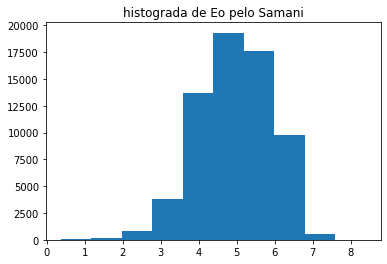

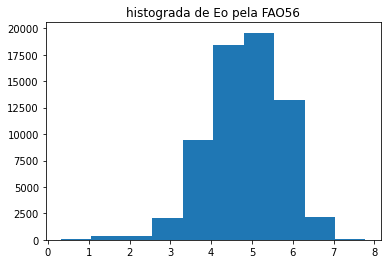

In [ ]:
#display(eo)
eo=pd.Series(eo_samani)
eo=pd.Series(eo_fao)
plt.hist(eo_samani)
plt.title('histograda de Eo pelo Samani')
plt.show()
plt.hist(eo_fao)
plt.title('histograda de Eo pela FAO56')
plt.show()

In [ ]:
display(data)

,TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MAX. NA HORA ANT. (AUT)(%),TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C),UMIDADE REL. MIN. NA HORA ANT. (AUT)(%),RADIACAO GLOBAL(Kj/m²),"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)","UMIDADE RELATIVA DO AR, HORARIA(%)","VENTO, VELOCIDADE HORARIA(m/s)",latitude,longitude,altura,dia do ano,data completa,temperatura media,Eo_samani,Eo_FAO
0,29.6,84.0,26.7,68.0,2478.500000,1008.690909,77.636364,2.381818,-0.066599,-0.672610,29.55,49,2003-02-18,28.15,2.815185,2.158130
1,31.5,95.0,24.3,62.0,1320.500000,1008.700000,80.750000,2.329167,-0.066599,-0.672610,29.55,50,2003-02-19,27.90,4.412632,4.312026
2,27.6,95.0,24.1,78.0,2386.444444,1008.354167,88.333333,1.279167,-0.066599,-0.672610,29.55,51,2003-02-20,25.85,2.939072,3.032922
3,30.8,96.0,22.0,61.0,1246.666667,1008.354167,83.083333,1.708333,-0.066599,-0.672610,29.55,52,2003-02-21,26.40,4.719712,4.768149
4,31.2,94.0,24.2,59.0,1431.000000,1008.283333,82.041667,1.858333,-0.066599,-0.672610,29.55,53,2003-02-22,27.70,4.333662,4.317706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65718,36.8,42.0,31.7,31.0,3055.208250,988.400000,33.500000,3.075000,-0.086896,-0.681677,193.00,339,2019-12-05,34.25,4.155351,3.864984
65719,37.6,33.0,34.7,28.0,2419.698000,985.700000,29.000000,2.200000,-0.086896,-0.681677,193.00,341,2019-12-07,36.15,3.246348,2.578275
65720,34.9,67.0,29.4,40.0,1530.386800,988.720000,51.200000,2.600000,-0.086896,-0.681677,193.00,342,2019-12-08,32.15,4.138430,3.941287
65721,35.1,76.0,26.6,36.0,2624.976200,989.040000,45.400000,3.860000,-0.086896,-0.681677,193.00,343,2019-12-09,30.85,5.009957,4.618717


In [ ]:
data.to_csv('meteorological_data.csv',index=False)